In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [15,12]

pd.options.display.max_columns = None

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(134683, 21)

In [4]:
test.shape

(57722, 21)

In [9]:
train.head(2)

,Property_ID,room,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,parking_spaces,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood
0,42208,3,BHK,Independent House,Palavakkam,33624,1312,Furnished,2,Chennai,1,1,1,0,0,1,0,302616,0,0,300
1,90879,1,BHK,Apartment,Manikonda,9655,1474,Unfurnished,2,Hyderabad,0,17,0,1,0,0,1,19310,0,1,1600


# Base Model

* Regression Model

In [12]:
test['price'] = train.price.mean()   # base model

solution = pd.DataFrame({'price':test.price})

In [13]:
# export the data outside

solution.to_csv('Basemodel.csv', index = False)   # RMSE: 60600

In [15]:
test = test.drop('price', axis = 1)

### Combined the Data and start EDA

* univariate
* bivariate
* missing values
* outliers
* Feature Engineering
* If needed we will scale the data

* model building - Decision Tree, Random Forest....

In [16]:
combined = pd.concat([train, test], ignore_index = True)

In [17]:
combined.shape

(192405, 21)

In [18]:
combined.isnull().sum()

Property_ID             0
room                    0
layout_type             0
property_type           0
locality                0
price               57722
area                    0
furnish_type            0
bathroom                0
city                    0
parking_spaces          0
floor                   0
pet_friendly            0
power_backup            0
washing_machine         0
air_conditioner         0
geyser/solar            0
security_deposit        0
CCTV/security           0
lift                    0
neighbourhood           0
dtype: int64

In [21]:
combined.columns

Index(['Property_ID', 'room', 'layout_type', 'property_type', 'locality',
       'price', 'area', 'furnish_type', 'bathroom', 'city', 'parking_spaces',
       'floor', 'pet_friendly', 'power_backup', 'washing_machine',
       'air_conditioner', 'geyser/solar', 'security_deposit', 'CCTV/security',
       'lift', 'neighbourhood'],
      dtype='object')

In [22]:
combined['lift'] = combined.lift.astype('object')
combined['geyser/solar'] = combined['geyser/solar'].astype('object')
combined['CCTV/security'] = combined['CCTV/security'].astype('object')
combined['air_conditioner'] = combined['air_conditioner'].astype('object')
combined['washing_machine'] = combined['washing_machine'].astype('object')
combined['power_backup'] = combined['power_backup'].astype('object')
combined['pet_friendly'] = combined['pet_friendly'].astype('object')
combined['parking_spaces'] = combined['parking_spaces'].astype('object')

In [23]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192405 entries, 0 to 192404
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Property_ID       192405 non-null  int64  
 1   room              192405 non-null  int64  
 2   layout_type       192405 non-null  object 
 3   property_type     192405 non-null  object 
 4   locality          192405 non-null  object 
 5   price             134683 non-null  float64
 6   area              192405 non-null  int64  
 7   furnish_type      192405 non-null  object 
 8   bathroom          192405 non-null  int64  
 9   city              192405 non-null  object 
 10  parking_spaces    192405 non-null  object 
 11  floor             192405 non-null  int64  
 12  pet_friendly      192405 non-null  object 
 13  power_backup      192405 non-null  object 
 14  washing_machine   192405 non-null  object 
 15  air_conditioner   192405 non-null  object 
 16  geyser/solar      19

In [25]:
# Numerical variables

nums = combined.select_dtypes(include = np.number)

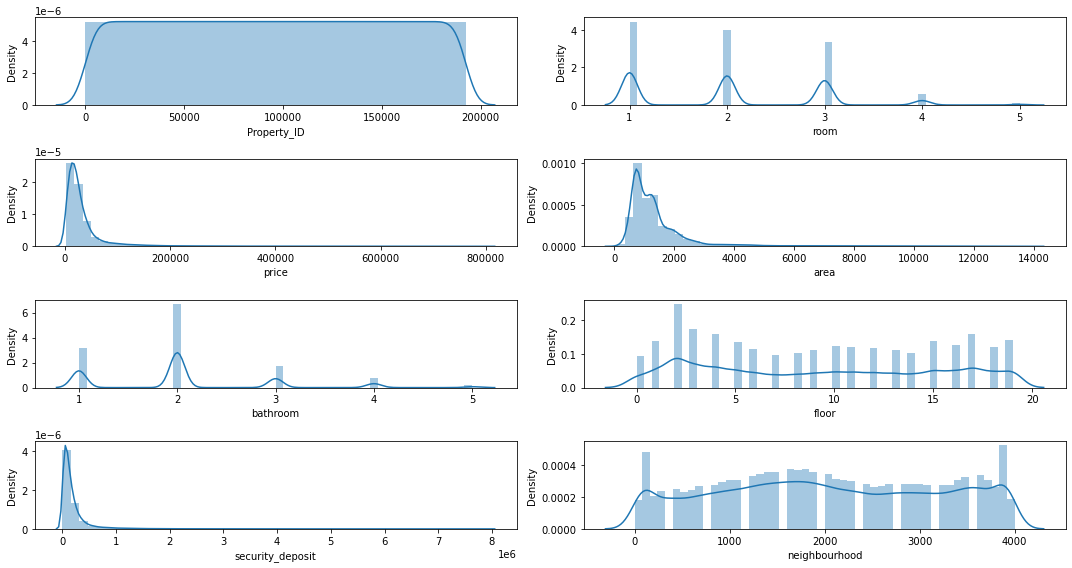

In [28]:
a = 4
b = 2
c = 1

for i in nums.columns:
    plt.subplot(a,b,c)
    sns.distplot(nums.loc[:,i])
    plt.xlabel(i)
    c = c +1
plt.tight_layout()
plt.show()

* security deposit, Price along with area appears to be skewed
* we need to look into neighborhood distance
* No of bathrooms aoopear to be 2 in most of the cases

In [30]:
# Categories Data

cats = combined.select_dtypes(include = 'object')

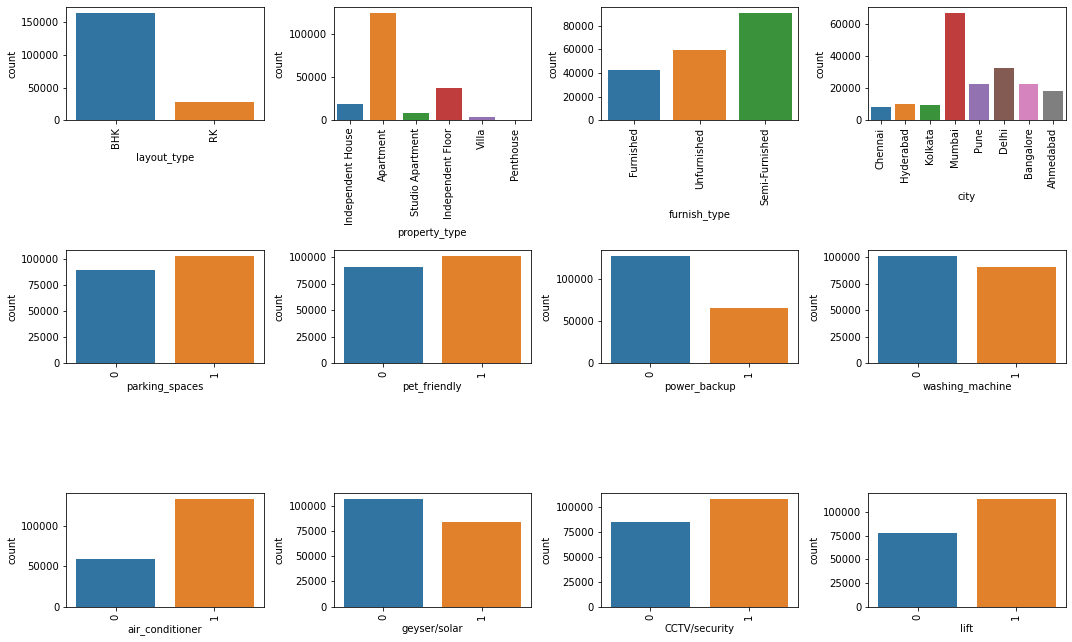

In [36]:
a = 4
b = 4
c = 1

for i in cats.drop(['locality'], axis = 1).columns:
    plt.subplot(a,b,c)
    sns.countplot(cats.loc[:,i])
    plt.xlabel(i)
    plt.xticks(rotation = 90)
    c = c +1
plt.tight_layout()
plt.show()

1. Most of the houses are:
    * have lift
    * have geysers
    * have ACs followed by no washing machine
    * No power backup
    * They are pet friendly houses
    * They have parking spaces, in Mumbai mostly and semi-furnished apartments

## Bivariate Analysis

In [37]:
nums.columns

Index(['Property_ID', 'room', 'price', 'area', 'bathroom', 'floor',
       'security_deposit', 'neighbourhood'],
      dtype='object')

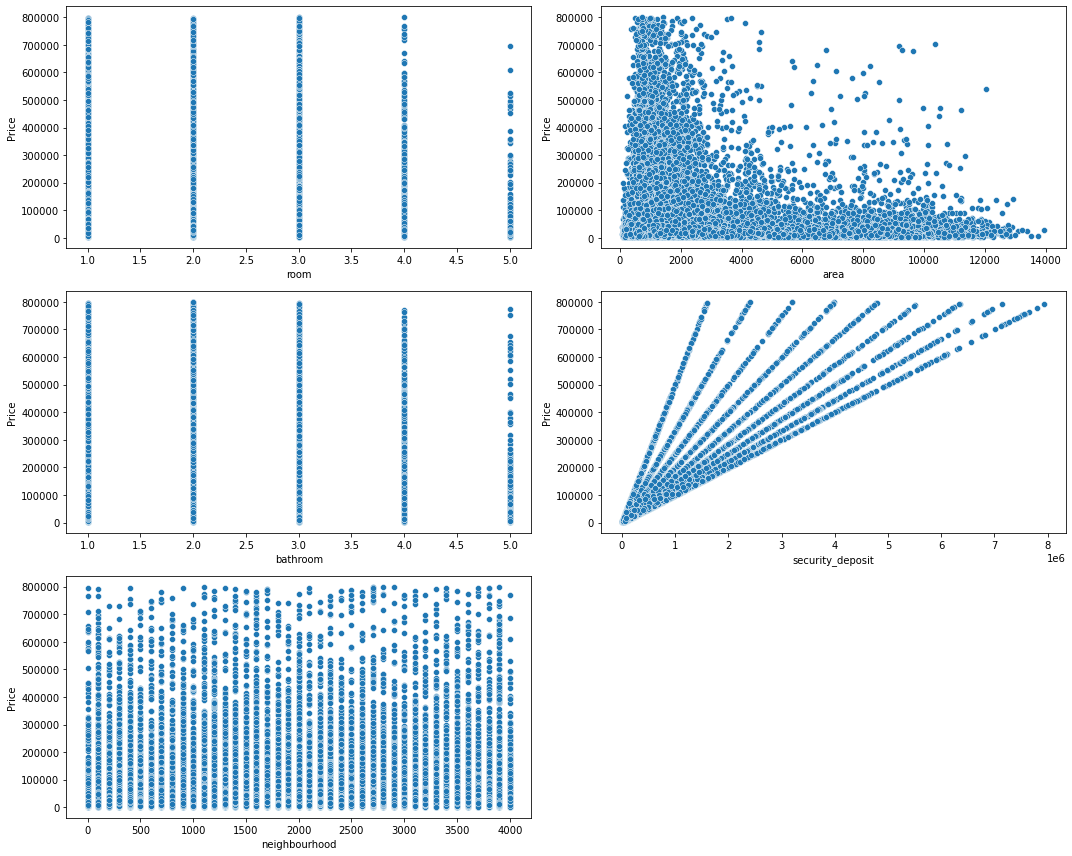

In [38]:
cols = ['room', 'area', 'bathroom', 'security_deposit', 'neighbourhood']

a = 3
b = 2
c = 1

for i in cols:
    plt.subplot(a,b,c)
    sns.scatterplot(x = combined.loc[:,i], y = combined.price)
    plt.xlabel(i)
    plt.ylabel('Price')
    c = c + 1
    
plt.tight_layout()
plt.show()

<AxesSubplot:>

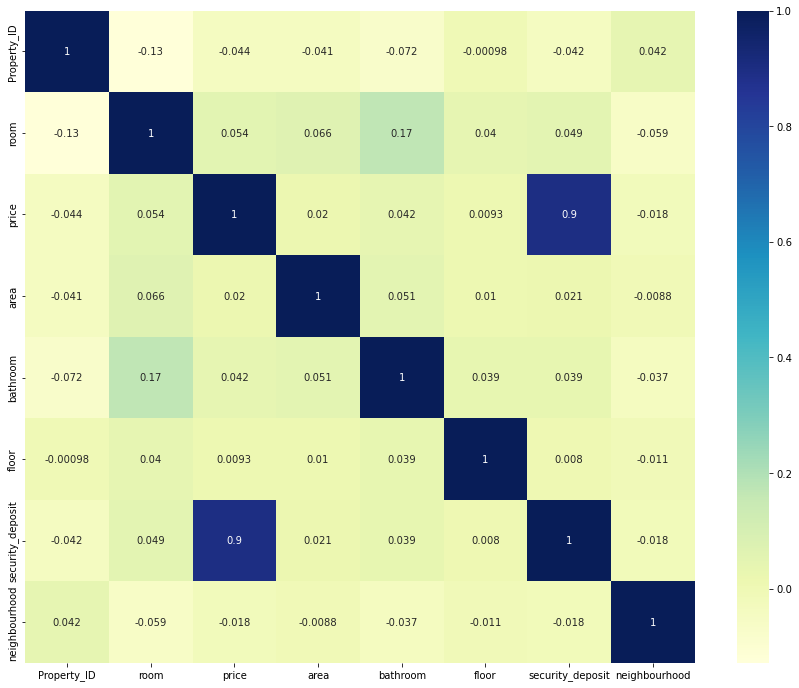

In [40]:
sns.heatmap(nums.corr(), annot = True, cmap = 'YlGnBu')

In [41]:
train.loc[:,['security_deposit','price']].describe()

,security_deposit,price
count,1.346830e+05,134683.000000
mean,2.202480e+05,36690.033894
std,4.204503e+05,62620.364025
min,3.180000e+03,1583.000000
25%,5.580250e+04,12035.500000
50%,1.142640e+05,20856.000000
75%,2.207045e+05,36014.000000
max,7.940780e+06,799325.000000


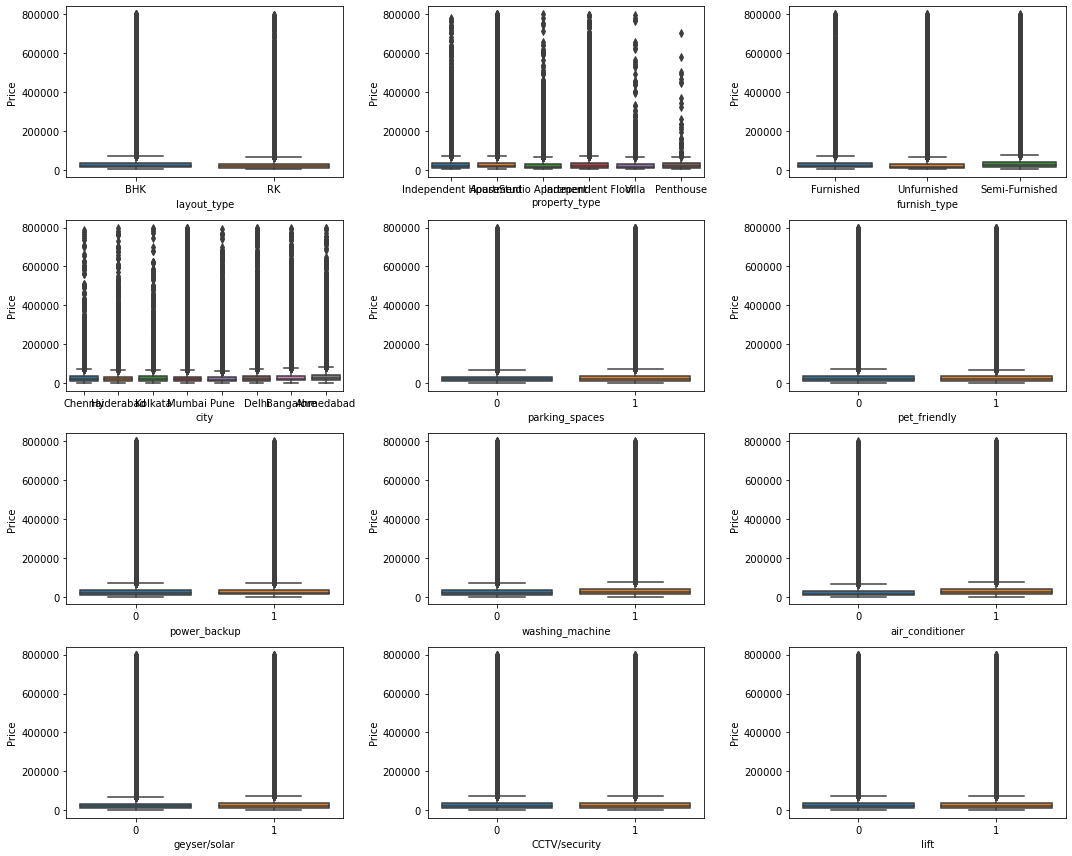

In [46]:
cols = ['layout_type', 'property_type','furnish_type', 'city',
       'parking_spaces', 'pet_friendly', 'power_backup', 'washing_machine',
       'air_conditioner', 'geyser/solar', 'CCTV/security', 'lift']

a = 4
b = 3
c = 1

for i in cols:
    plt.subplot(a,b,c)
    sns.boxplot(x = combined.loc[:,i], y = combined.price)
    plt.xlabel(i)
    plt.ylabel('Price')
    c = c + 1
    
plt.tight_layout()
plt.show()

## Feature Engineering

In [48]:
combined.head(2)

,Property_ID,room,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,parking_spaces,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood
0,42208,3,BHK,Independent House,Palavakkam,33624.0,1312,Furnished,2,Chennai,1,1,1,0,0,1,0,302616,0,0,300
1,90879,1,BHK,Apartment,Manikonda,9655.0,1474,Unfurnished,2,Hyderabad,0,17,0,1,0,0,1,19310,0,1,1600


In [53]:
combined.property_type.unique()

array(['Independent House', 'Apartment', 'Penthouse'], dtype=object)

In [50]:
combined.replace(to_replace = ['Studio Apartment', 'Independent Floor'],
                value = ['Apartment','Apartment'], inplace = True)

In [52]:
combined.replace(to_replace = 'Villa',
                value = 'Independent House' , inplace = True)

In [54]:
combined.layout_type.unique()

array(['BHK', 'RK'], dtype=object)

In [55]:
combined.locality.unique()

array(['Palavakkam', 'Manikonda', 'Jodhpur Park', ...,
       'Dhanalakshmi Layout', 'Kalyani Nagar Annexe',
       'Neeladri Investment Layout 6th Main Road'], dtype=object)

In [56]:
combined.city.unique()

array(['Chennai', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune', 'Delhi',
       'Bangalore', 'Ahmedabad'], dtype=object)

In [57]:
# convert city into region

north = ['Delhi']
west = ['Mumbai', 'Ahmedabad', 'Pune']
south = ['Chennai', 'Hyderabad', 'Bangalore']

In [58]:
def meracity(x):
    if x in north:
        return('North')
    elif x in south:
        return('South')
    elif x in west:
        return('West')
    else:
        return('East')

In [59]:
combined['Region'] = combined.city.apply(meracity)

In [60]:
combined.head(2)

,Property_ID,room,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,parking_spaces,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood,Region
0,42208,3,BHK,Independent House,Palavakkam,33624.0,1312,Furnished,2,Chennai,1,1,1,0,0,1,0,302616,0,0,300,South
1,90879,1,BHK,Apartment,Manikonda,9655.0,1474,Unfurnished,2,Hyderabad,0,17,0,1,0,0,1,19310,0,1,1600,South


In [63]:
new = combined.drop(['Property_ID','city','locality'], axis = 1)

In [65]:
new.head()

,room,layout_type,property_type,price,area,furnish_type,bathroom,parking_spaces,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood,Region
0,3,BHK,Independent House,33624.0,1312,Furnished,2,1,1,1,0,0,1,0,302616,0,0,300,South
1,1,BHK,Apartment,9655.0,1474,Unfurnished,2,0,17,0,1,0,0,1,19310,0,1,1600,South
2,3,BHK,Apartment,23699.0,1837,Semi-Furnished,2,0,10,1,1,1,1,0,118495,0,1,3100,East
3,1,BHK,Apartment,6306.0,606,Unfurnished,1,0,18,0,0,0,0,0,37836,0,1,300,West
4,1,BHK,Apartment,12008.0,498,Semi-Furnished,3,0,14,0,0,1,1,0,72048,0,1,0,West


In [68]:
bhk = train.loc[train.layout_type == 'BHK','price']
rk = train.loc[train.layout_type == 'RK','price']

In [69]:
from scipy.stats import ttest_ind

ttest_ind(bhk,rk)
# hence important

Ttest_indResult(statistic=7.382484143859903, pvalue=1.5625315383553e-13)

In [73]:
new.furnish_type.unique()

array(['Furnished', 'Unfurnished', 'Semi-Furnished'], dtype=object)

In [74]:
pd.DataFrame(new.groupby('property_type')['furnish_type'].value_counts()).T

property_type      Apartment                       Independent House  \
furnish_type  Semi-Furnished Unfurnished Furnished    Semi-Furnished   
furnish_type           80980       50819     37324              9641   

property_type                            Penthouse                        
furnish_type  Unfurnished Furnished Semi-Furnished Unfurnished Furnished  
furnish_type         8011      4922            303         257       148

In [75]:
from scipy.stats import ttest_ind

ttest_ind(train.bathroom,train.price)

Ttest_indResult(statistic=-215.01302145772294, pvalue=0.0)

In [78]:
new = new.drop(['floor','room'], axis = 1)

In [79]:
new.head()

,layout_type,property_type,price,area,furnish_type,bathroom,parking_spaces,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood,Region
0,BHK,Independent House,33624.0,1312,Furnished,2,1,1,0,0,1,0,302616,0,0,300,South
1,BHK,Apartment,9655.0,1474,Unfurnished,2,0,0,1,0,0,1,19310,0,1,1600,South
2,BHK,Apartment,23699.0,1837,Semi-Furnished,2,0,1,1,1,1,0,118495,0,1,3100,East
3,BHK,Apartment,6306.0,606,Unfurnished,1,0,0,0,0,0,0,37836,0,1,300,West
4,BHK,Apartment,12008.0,498,Semi-Furnished,3,0,0,0,1,1,0,72048,0,1,0,West


In [81]:
pd.get_dummies(new, drop_first = True).shape

(192405, 21)

In [84]:
cols = ['area','security_deposit','neighbourhood']

df = new.loc[:,cols]

In [83]:
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer

In [85]:
model = KMeans(random_state = 1)
visuals = KElbowVisualizer(estimator = model, k = (2,10))

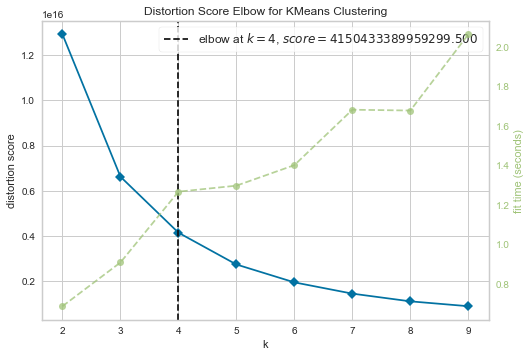

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [86]:
visuals.fit(df)
visuals.show()

In [88]:
sc = StandardScaler()

scaled = sc.fit_transform(df)

In [91]:
# DBSCAN
from sklearn.neighbors import NearestNeighbors

n = NearestNeighbors(n_neighbors = 2)

model = n.fit(scaled)

distance, index = model.kneighbors(df)

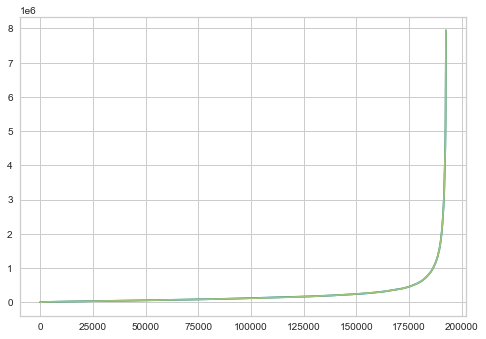

In [92]:
plt.plot(np.sort(distance, axis = 0))

## Model

* Decision Tree
* Random Forest
* Gradient Boosting

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [98]:
new.head(2)

,layout_type,property_type,price,area,furnish_type,bathroom,parking_spaces,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood,Region
0,BHK,Independent House,33624.0,1312,Furnished,2,1,1,0,0,1,0,302616,0,0,300,South
1,BHK,Apartment,9655.0,1474,Unfurnished,2,0,0,1,0,0,1,19310,0,1,1600,South


In [99]:
new.shape

(192405, 17)

In [100]:
train.shape, test.shape

((134683, 21), (57722, 20))

In [109]:
newtrain = new.loc[0:train.shape[0]-1,:]

In [110]:
newtest = new.loc[train.shape[0]:,:]

In [112]:
# Drop 
newtest = newtest.drop('price', axis = 1)

In [114]:
newtrain.shape , newtest.shape

((134683, 17), (57722, 16))

In [113]:
dummytrain = pd.get_dummies(newtrain, drop_first = True)
dummytest = pd.get_dummies(newtest, drop_first = True)

In [115]:
dummytrain.shape , dummytest.shape

((134683, 21), (57722, 20))

# Random Forest Model

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

X = dummytrain.drop('price', axis = 1)
y = dummytrain.price

cross_val_score(estimator = rf,
                X = X,
                y = y,
                cv = 5,
                scoring = 'neg_mean_squared_error')

array([-8.12286422e+08, -7.62219277e+08, -7.57583016e+08, -7.97845294e+08,
       -7.47693439e+08])

In [118]:
np.sqrt(np.abs([-8.12286422e+08, -7.62219277e+08, -7.57583016e+08, -7.97845294e+08,
       -7.47693439e+08]).mean())

27848.258286650533

In [119]:
# Build a random Forest Model

rf = RandomForestRegressor()

pred_rf = rf.fit(X,y).predict(dummytest)

In [120]:
solution = pd.DataFrame({'price':pred_rf})
solution.to_csv('RF Model.csv',index = False)

In [121]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
pred_gbr = gbr.fit(X,y).predict(dummytest)

solution = pd.DataFrame({'price':pred_rf})
solution.to_csv('GBR Model.csv',index = False)

In [122]:
cd

C:\Users\Shantanu


In [123]:
cross_val_score(estimator = gbr,
                X = X,
                y = y,
                cv = 5,
                scoring = 'neg_mean_squared_error')

array([-7.53739615e+08, -7.02951495e+08, -6.99380507e+08, -7.50721385e+08,
       -6.84797943e+08])

In [124]:
np.sqrt(np.abs([-7.53739615e+08, -7.02951495e+08, -6.99380507e+08, -7.50721385e+08,
       -6.84797943e+08]).mean())

26801.458710301573

In [125]:
!pip3 install lightgbm

In [126]:
import lightgbm as lgbm

In [127]:
light = lgbm.LGBMRegressor()
pred_light = light.fit(X, y).predict(dummytest)

In [128]:
import xgboost as xgb

In [129]:
xgb_r = xgb.XGBRegressor()

pred_xgb = xgb_r.fit(X,y).predict(dummytest)

In [130]:
predictions = pd.DataFrame(data = [pred_gbr, pred_light, pred_xgb]).T

In [131]:
predictions

,0,1,2
0,17818.920622,17811.757879,18414.507812
1,7096.344739,6502.616317,7225.642090
2,3302.498711,2994.953370,3387.749023
3,25368.031030,24838.874308,24988.609375
4,22937.023981,22675.479227,23775.406250
...,...,...,...
57717,19915.277411,20375.256318,21017.017578
57718,6361.161197,6764.353528,6795.042480
57719,31753.588416,31196.471040,31518.000000
57720,19606.033095,19443.883720,19122.654297


In [132]:
solution = pd.DataFrame({'price':predictions.mean(axis = 1)})
solution.to_csv('FinalSubmission.csv', index = False)